In [1]:
import tensorflow as tf

In [2]:
from PIL.Image import open
from numpy import array, float32, reshape

In [3]:
from watermarking import training

In [4]:
from re import sub, search
from os import listdir
from numpy import expand_dims, uint8, mean, asarray, flip
from watermarking import embedding, process, extraction, cnn

<h3>Change Watermark to One-Hot</h3>

In [5]:
def WM_to_one_hot(wm):
    one_hot = []
    for row in wm:
        new_row = []
        for _px in row:
            new_row.append(
                [0, 1] if _px == 0 else [1, 0]
            )
        one_hot.append(new_row)
    return array(one_hot)

def WMs_to_one_hot(wms):
    one_hot_wms = []
    for wm in wms:
        one_hot_wms.append(WM_to_one_hot(wm))
    return array(one_hot_wms)

In [6]:
train = training.Training()

initializing
enc   0  ->  64
dec   0  ->  64


In [7]:
attacked_watermarks = WMs_to_one_hot(
    train.normalize_watermark(
        train.apply_transformations(
            open("Watermark.tiff"), iswatermark=True
        )
    )
)


In [8]:
test = train.normalize_watermark(
    train.apply_transformations(
        open("Watermark.tiff"), iswatermark=True
    )
)

In [9]:
watermark = open("Watermark.tiff")

<h3>Load Training Images</h3>

In [10]:
def create_train_label(wms, total_img):
    train_label = []
    attack_i = 0
    for i in range(total_img):
        train_label.append(wms[0])
        attack_i += 1
        if attack_i == 24:
            attack_i = 0
    return array(train_label)

In [11]:
training_images_filename = listdir(train.PRE_TRAINING_PATH)
train_imgs = []
for filename in training_images_filename:
    image = open(train.PRE_TRAINING_PATH + "/" + filename)
    full_path = train.TRAINING_PATH + "/" + sub(
       search(".tif+$", filename).group(), "", filename
    )
    embedding.Embedding().embed_watermark(
        process.Process.pil_to_open_cv(
            image
        ),
        array(watermark, dtype=uint8),
        full_path
    )
    image = open(full_path + ".tif")
    train_imgs.extend(
        expand_dims(
            train.normalize_embedding_maps(
                train.get_embedding_maps(                   
                    train.apply_transformations(image),
                    extraction.Extraction().extract_key_from_pil_image(image)
                )
            ), axis=3
        )
    )

total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24


In [12]:
train_imgs = array(train_imgs)

In [13]:
train_imgs.shape

(960, 64, 64, 1)

In [14]:
train_label = create_train_label(attacked_watermarks, train_imgs.shape[0])

<h3>Model</h3>

In [ ]:
def compute_nc(inputs):
    labels = inputs[0]
    preds = inputs[1]
    
    summed = []
    for i, pred in enumerate(preds):
        summed.append(
            extraction.Extraction.normalized_correlation_coef(
                labels[i], pred
            )
        )
    print('\n', summed)
    return mean(summed, axis=0)

@tf.function 
def tf_function(input): 
    return tf.numpy_function(compute_nc, [input], tf.float32) 

class normalized_correlation_coef(tf.keras.metrics.Metric):
    def __init__(self, name="normalized correlation", **kwargs):
        super(normalized_correlation_coef, self).__init__(name=name, **kwargs)
        self.true_positives = 0

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.true_positives = tf_function([y_true, y_pred])

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives = 0.0

In [15]:
model = tf.keras.Sequential([
    # encoder
    tf.keras.layers.Conv2D(
        8, 7, input_shape=(64, 64, 1), activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
    tf.keras.layers.Conv2D(
        8, 7, activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    # decoder
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(
        1, 7, activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
    tf.keras.layers.Conv2D(
        1, 7, activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        2, 7, activation = 'softmax', padding= 'same', kernel_initializer = 'random_normal', use_bias=False
    )
])

model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         3136      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 1)         392       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 1)         49        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 2)         9

In [17]:
history = model.fit(
    train_imgs,
    train_label,
    epochs=100,
    batch_size=24,
    verbose=0
)

In [18]:
history.history['accuracy']

[0.36276042461395264,
 0.3541427552700043,
 0.35272547602653503,
 0.35458603501319885,
 0.3616833984851837,
 0.3708640933036804,
 0.37802785634994507,
 0.3857426941394806,
 0.38455429673194885,
 0.37404659390449524,
 0.3682818114757538,
 0.365164190530777,
 0.36363551020622253,
 0.36325937509536743,
 0.36298269033432007,
 0.36324945092201233,
 0.36451035737991333,
 0.3672276735305786,
 0.37202808260917664,
 0.3855428099632263,
 0.4242716431617737,
 0.4560803771018982,
 0.5151415467262268,
 0.6405103206634521,
 0.6419374942779541,
 0.6845418214797974,
 0.6655044555664062,
 0.6917180418968201,
 0.7046579718589783,
 0.7013417482376099,
 0.7235949039459229,
 0.7174184322357178,
 0.7213353514671326,
 0.7300521731376648,
 0.7240588068962097,
 0.7419782280921936,
 0.7399991154670715,
 0.7425277829170227,
 0.7390581965446472,
 0.7428049445152283,
 0.7431541681289673,
 0.7476369142532349,
 0.7509239315986633,
 0.7502893805503845,
 0.7521883845329285,
 0.7522618770599365,
 0.7524556517601013,
 0

In [19]:
image = open("static/training/bird.tif")

In [20]:
ext = extraction.Extraction()

In [21]:
key = ext.extract_key_from_pil_image(image)

In [22]:
em = expand_dims(ext.get_embedding_map(process.Process.pil_to_open_cv(image), key), axis=2)

In [23]:
result = model.predict(expand_dims(em, axis=0))

In [24]:
classified = []
for row in result[0]:
    new_row = []
    for _px in row:
        new_row.append(
            255 if _px[0] > _px[1] else 0
        )
    classified.append(new_row)

In [25]:
from matplotlib.pyplot import imshow

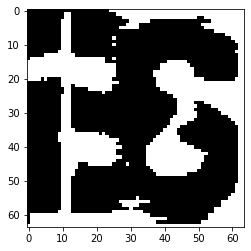

In [26]:
imshow(classified, cmap='gray')

In [27]:
extraction.Extraction.normalized_correlation_coef(classified, watermark)

0.8677363022278513

In [28]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [29]:
layer_dict

{'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x291aa6a6ac0>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x291ac0039a0>,
 'max_pooling2d': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x291ac003b20>,
 'up_sampling2d': <tensorflow.python.keras.layers.convolutional.UpSampling2D at 0x291ac003f40>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x291aa702280>,
 'conv2d_3': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x291aa702730>,
 'conv2d_4': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x291aa702bb0>}

<h3>Change Weight Shape</h3>

In [147]:
weight = layer_dict['conv2d_4'].weights

In [148]:
weight = weight[0].numpy()

In [149]:
weight.shape

(7, 7, 1, 2)

In [150]:
weight

array([[[[ 0.04316763, -0.03303267]],

        [[ 0.06682368, -0.00742341]],

        [[ 0.0869441 , -0.02138923]],

        [[ 0.08281847, -0.05818615]],

        [[-0.03665007,  0.01794455]],

        [[ 0.00839506,  0.03650714]],

        [[-0.11186419,  0.03926112]]],


       [[[ 0.03044833, -0.01200793]],

        [[ 0.13373831, -0.08504973]],

        [[ 0.10591376, -0.04651026]],

        [[ 0.03968359, -0.12539391]],

        [[-0.04779579, -0.08171887]],

        [[-0.02620913, -0.02801159]],

        [[-0.05442336,  0.03498431]]],


       [[[ 0.00906968, -0.00655599]],

        [[ 0.10251174, -0.02335571]],

        [[ 0.10337612, -0.02080983]],

        [[ 0.10089402, -0.13070235]],

        [[-0.0421761 , -0.05070487]],

        [[-0.0394932 , -0.06776013]],

        [[-0.03985071, -0.03043484]]],


       [[[ 0.0753427 ,  0.03213975]],

        [[ 0.07398187, -0.07082447]],

        [[ 0.05189873, -0.0803712 ]],

        [[ 0.08343481, -0.12669298]],

        [[ 0.048659

In [151]:
def reverse_shape(weight):
    """7718 -> 8177"""
    ch_number = weight.shape[3]
    input_number = weight.shape[2]
    new_weight = []
    for i in range(ch_number):
        new_channel = []
        for j in range(input_number):
            new_input = []
            for row in weight:
                new_row = []
                for _px in row:
                    new_row.append(_px[j][i])
                new_input.append(new_row)
            new_channel.append(new_input)
        new_weight.append(new_channel)
    return new_weight

In [ ]:
def fix_reverse_shape(weight):
    """877 -> 778"""
    (i_number, w, h) = weight.shape
    new_weight = np.zeros((w, h, i_number))
    for i in range(i_number):
        for j in range(w):
            for k in range(h):
                new_weight[j, k, i] = weight[i, j, k]
    return new_weight

In [152]:
reversed_weight = array(reverse_shape(weight))

In [153]:
reversed_weight

array([[[[ 0.04316763,  0.06682368,  0.0869441 ,  0.08281847,
          -0.03665007,  0.00839506, -0.11186419],
         [ 0.03044833,  0.13373831,  0.10591376,  0.03968359,
          -0.04779579, -0.02620913, -0.05442336],
         [ 0.00906968,  0.10251174,  0.10337612,  0.10089402,
          -0.0421761 , -0.0394932 , -0.03985071],
         [ 0.0753427 ,  0.07398187,  0.05189873,  0.08343481,
           0.04865968,  0.02708725, -0.01238233],
         [-0.06512541, -0.02592531, -0.02704103,  0.03484771,
          -0.10288414, -0.11858482, -0.07876291],
         [-0.02030687, -0.02019893,  0.00317987, -0.00965749,
          -0.06700617, -0.01950512, -0.0839007 ],
         [-0.0709728 , -0.05601174, -0.07669152, -0.09271009,
          -0.11072642, -0.05567117, -0.10967121]]],


       [[[-0.03303267, -0.00742341, -0.02138923, -0.05818615,
           0.01794455,  0.03650714,  0.03926112],
         [-0.01200793, -0.08504973, -0.04651026, -0.12539391,
          -0.08171887, -0.02801159,  0

In [154]:
def create_param_dict(weight, prefix):
    param = {}
    for i, channel in enumerate(weight):
        for j, matrix in enumerate(channel):
            param[prefix + '-' + str(i) + '-' + str(j)] = matrix
    return param

In [144]:
param_dict = create_param_dict(reversed_weight, 'dec0-1')

In [155]:
reversed_weight = reversed_weight.reshape((2,7,7))
param_dict = {
    'softmax-bg': reversed_weight[1],
    'softmax-fg': reversed_weight[0]
}

In [156]:
param_dict

{'softmax-bg': array([[-0.03303267, -0.00742341, -0.02138923, -0.05818615,  0.01794455,
          0.03650714,  0.03926112],
        [-0.01200793, -0.08504973, -0.04651026, -0.12539391, -0.08171887,
         -0.02801159,  0.03498431],
        [-0.00655599, -0.02335571, -0.02080983, -0.13070235, -0.05070487,
         -0.06776013, -0.03043484],
        [ 0.03213975, -0.07082447, -0.0803712 , -0.12669298, -0.02449327,
         -0.00041497, -0.01127758],
        [ 0.06514283,  0.09530184,  0.03749429,  0.02019124,  0.09717952,
          0.06190836,  0.02643731],
        [ 0.03022633,  0.02502816,  0.02993851, -0.00285827,  0.04061338,
          0.00214494,  0.07239456],
        [ 0.06723273,  0.01482248, -0.00388164, -0.02289069,  0.0624611 ,
          0.1178866 ,  0.09226809]], dtype=float32),
 'softmax-fg': array([[ 0.04316763,  0.06682368,  0.0869441 ,  0.08281847, -0.03665007,
          0.00839506, -0.11186419],
        [ 0.03044833,  0.13373831,  0.10591376,  0.03968359, -0.04779579,
 

In [157]:
cnn.CNN.store_param(param_dict)

<h3>Get Visualization Model</h3>

In [52]:
outputs = [layer.output for layer in model.layers[1:]]

In [53]:
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = outputs)

In [54]:
feature_maps = visualization_model.predict(array([train_imgs[0]]))

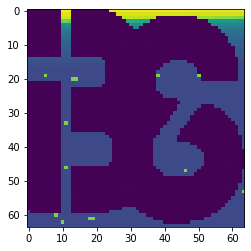

In [55]:
imshow(array(train_imgs[0]).reshape((64, 64)))

In [103]:
array(train_imgs[0]).reshape((64, 64))

array([[ 34.,  34.,  34., ..., 212., 212., 212.],
       [ 34.,  34.,  34., ..., 206., 206., 206.],
       [ 34.,  34.,  34., ..., 184., 184., 183.],
       ...,
       [ 74.,  74.,  74., ...,  74.,  74.,  74.],
       [ 74.,  74.,  74., ...,  74.,  74.,  74.],
       [ 74.,  74.,  74., ...,  74.,  74.,  74.]])

In [56]:
def reverse_shape_fm(feature_map):
    ch_number = feature_map.shape[2]
    new_fm = []
    for i in range(ch_number):
        new_channel = []
        for row in feature_map:
            new_row = []
            for _px in row:
                new_row.append(_px[i])
            new_channel.append(new_row)
        new_fm.append(new_channel)
    return new_fm

In [57]:
array(feature_maps[5]).shape

(1, 64, 64, 2)

In [58]:
reversed_fm = reverse_shape_fm(feature_maps[0][0])

In [59]:
from matplotlib.pyplot import figure

In [60]:
array(reversed_fm).shape

(8, 64, 64)

In [61]:
array(reversed_fm)

array([[[ 0.6040822 ,  0.        ,  0.        , ...,  1.2195082 ,
          1.0124474 ,  0.        ],
        [ 2.7981534 ,  0.        ,  0.72600055, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  3.2253866 ],
        ...,
        [29.010277  , 24.753557  , 30.399986  , ...,  0.        ,
          3.2296133 ,  4.7248287 ],
        [14.761791  , 14.6932535 , 19.666828  , ...,  1.526824  ,
          8.590334  , 13.273735  ],
        [13.788467  , 16.279144  , 27.024467  , ..., 18.871645  ,
         19.779018  , 25.180862  ]],

       [[ 2.1733608 ,  1.8065307 ,  3.5839624 , ...,  0.        ,
          0.        ,  2.1176786 ],
        [ 1.6988473 ,  2.2372084 ,  6.200533  , ...,  0.        ,
          7.449803  , 11.233598  ],
        [ 0.        ,  0.        ,  1.4995111 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  6.989583  , ...,  

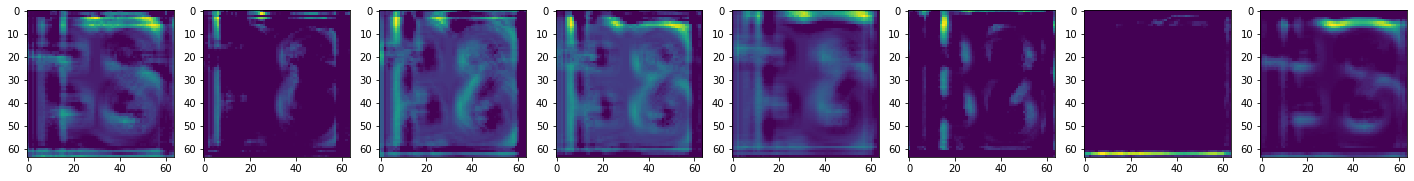

In [51]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [119]:
a = tf.keras.layers.Conv2D(
    8, 7, input_shape=(64, 64, 1), padding = 'same', kernel_initializer=tes, use_bias=False
)(array([train_imgs[0]]))

(7, 7, 1, 8)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [118]:
def tes(shape, dtype=None):
    w = layer_dict['conv2d'].weights[0].numpy()
    print(w.shape)
#     w[tuple(map(lambda x: int(np.floor(x/2)), w.shape))]=1
    return w

In [ ]:
a = a.numpy()

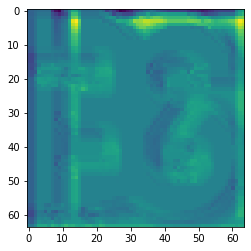

In [159]:
imshow(reverse_shape_fm(a[0])[3])

In [121]:
a.numpy().shape

(1, 64, 64, 8)

In [161]:
tf.keras.layers.UpSampling2D()(a.numpy())

<tf.Tensor: shape=(1, 128, 128, 8), dtype=float32, numpy=
array([[[[  21.968494  ,  -10.11744   ,    4.2020807 , ...,
            -3.7001157 ,   -0.8948494 ,  -10.002137  ],
         [  21.968494  ,  -10.11744   ,    4.2020807 , ...,
            -3.7001157 ,   -0.8948494 ,  -10.002137  ],
         [  20.831596  ,  -12.792362  ,    6.7517614 , ...,
            -9.160358  ,   -2.191156  ,   -4.4719534 ],
         ...,
         [ -14.825103  , -108.907364  ,   29.794392  , ...,
           -89.17079   ,  -49.924133  ,  -14.512537  ],
         [ -50.135323  ,  -82.78386   ,   16.903257  , ...,
           -87.95253   ,  -22.37598   ,   -1.1489921 ],
         [ -50.135323  ,  -82.78386   ,   16.903257  , ...,
           -87.95253   ,  -22.37598   ,   -1.1489921 ]],

        [[  21.968494  ,  -10.11744   ,    4.2020807 , ...,
            -3.7001157 ,   -0.8948494 ,  -10.002137  ],
         [  21.968494  ,  -10.11744   ,    4.2020807 , ...,
            -3.7001157 ,   -0.8948494 ,  -10.002137  ]

In [160]:
a.shape

TensorShape([1, 64, 64, 8])